In [1]:
import numpy as np
from sklearn.externals import joblib
import copy
import random
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import metrics

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
mp.rcParams.update({'font.size': 22})

In [4]:
datadict = joblib.load("Two_Port_Standard_Dictionary_Cleaned_Interpolated.pkl")

In [5]:
num_fake_points = 15000
magS11_deviation = 0.003
magS21_deviation = 0.000005
magS22_deviation = 0.0005
frequency_range = np.linspace(0.2,18,50)

In [6]:
magS11_points = []
magS21_points = []
magS22_points = []
for i in range(num_fake_points):
    new_dataset = copy.deepcopy(datadict['C07203']['HP8510'][random.choice(datadict['C07203']['HP8510'].keys())])
    new_dataset["magS11"] += np.random.normal(0,magS11_deviation,50)
    new_dataset["magS21"] += np.random.normal(0,magS21_deviation,50)
    new_dataset["magS22"] += np.random.normal(0,magS22_deviation,50)
    magS11_points.append(new_dataset["magS11"].tolist())
    magS21_points.append(new_dataset["magS21"].tolist())
    magS22_points.append(new_dataset["magS22"].tolist())
magS11_arr = np.array(magS11_points)
magS21_arr = np.array(magS21_points)
magS22_arr = np.array(magS22_points)

In [7]:
names = ["Gaussian Naive Bayes",
         "Decision Tree",
         "Random Forest",
         "Quadratic Discriminant Analysis",
         "Voting"]
classifiers = [GaussianNB(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               QuadraticDiscriminantAnalysis(),
               VotingClassifier(estimators=[
                   ('gnb',GaussianNB()),
                   ('rf',RandomForestClassifier()),
                   ('dt',DecisionTreeClassifier()),
                   ('qda',QuadraticDiscriminantAnalysis())
               ],voting="soft")]

In [8]:
def get_predicted_data(randomness_amplitude,classifier):
    incorrect_magS21_data = copy.deepcopy(magS21_arr)
    for i in range(len(incorrect_magS21_data)):
        incorrect_magS21_data[i] = (incorrect_magS21_data[i] + np.random.normal(0,randomness_amplitude,50))
    #Making training and test data
    S21_training_data = []
    S21_training_data.extend(incorrect_magS21_data.tolist())
    S21_training_data.extend(magS21_arr.tolist())
    S21_training_data_arr = np.array(S21_training_data)
    targets = ["not valid","valid"]
    S21_target_arr = np.repeat(targets,len(magS21_arr))
    S21_training_data_arr,S21_target_arr = shuffle(S21_training_data_arr,S21_target_arr, random_state=0)
    #Cloning and Training Classifier
    clf = clone(classifier)
    clf.fit(S21_training_data_arr[:len(magS21_arr)],S21_target_arr[:len(magS21_arr)])
    #Predicting Stuff
    predicted = clf.predict(S21_training_data_arr[len(magS21_arr):])
    #Getting prediction data
    valid_prediction_data = []
    invalid_prediction_data = []
    for i in range(len(predicted)):
        if predicted[i] == "valid":
            valid_prediction_data.append(S21_training_data_arr[len(magS21_arr) + i])
        else:
            invalid_prediction_data.append(S21_training_data_arr[len(magS21_arr) + i])
    return (valid_prediction_data, invalid_prediction_data)

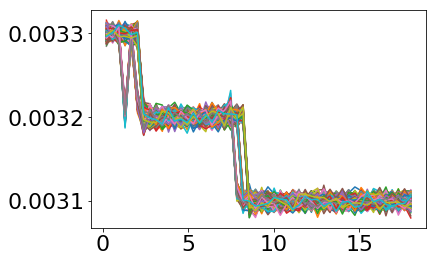

In [9]:
for i in range(500):
    plt.plot(frequency_range,magS21_arr[i])
plt.show()

In [10]:
randomness_amplitudes = [0.000001,0.000005,0.00002,0.00005,0.0001]

In [11]:
plt.figure(figsize=(8*len(randomness_amplitudes),6*len(classifiers)))
j=1
num_plot_points = 500
for index in range(len(classifiers)):
    for amp in range(len(randomness_amplitudes)):
        plt.subplot(len(classifiers),len(randomness_amplitudes),j)
        valid_prediction_data,invalid_prediction_data = get_predicted_data(randomness_amplitudes[amp],classifiers[index])
        plt.title("Classifier: " + names[index] + "\nAmplitude: " + str(randomness_amplitudes[amp]))
        if(len(invalid_prediction_data) >= num_plot_points):
            for i in range(num_plot_points):
                plt.plot(frequency_range,invalid_prediction_data[i],"b")
        else:
            for i in range(len(invalid_prediction_data)):
                plt.plot(frequency_range,invalid_prediction_data[i],"b")
        if(len(valid_prediction_data) >= num_plot_points):
            for i in range(num_plot_points):
                plt.plot(frequency_range,valid_prediction_data[i],"r")
        else:
            for i in range(len(valid_prediction_data)):
                plt.plot(frequency_range,valid_prediction_data[i],"r")
        j+=1
    print "finished a classifier!"

finished a classifier!
finished a classifier!
finished a classifier!
finished a classifier!
finished a classifier!


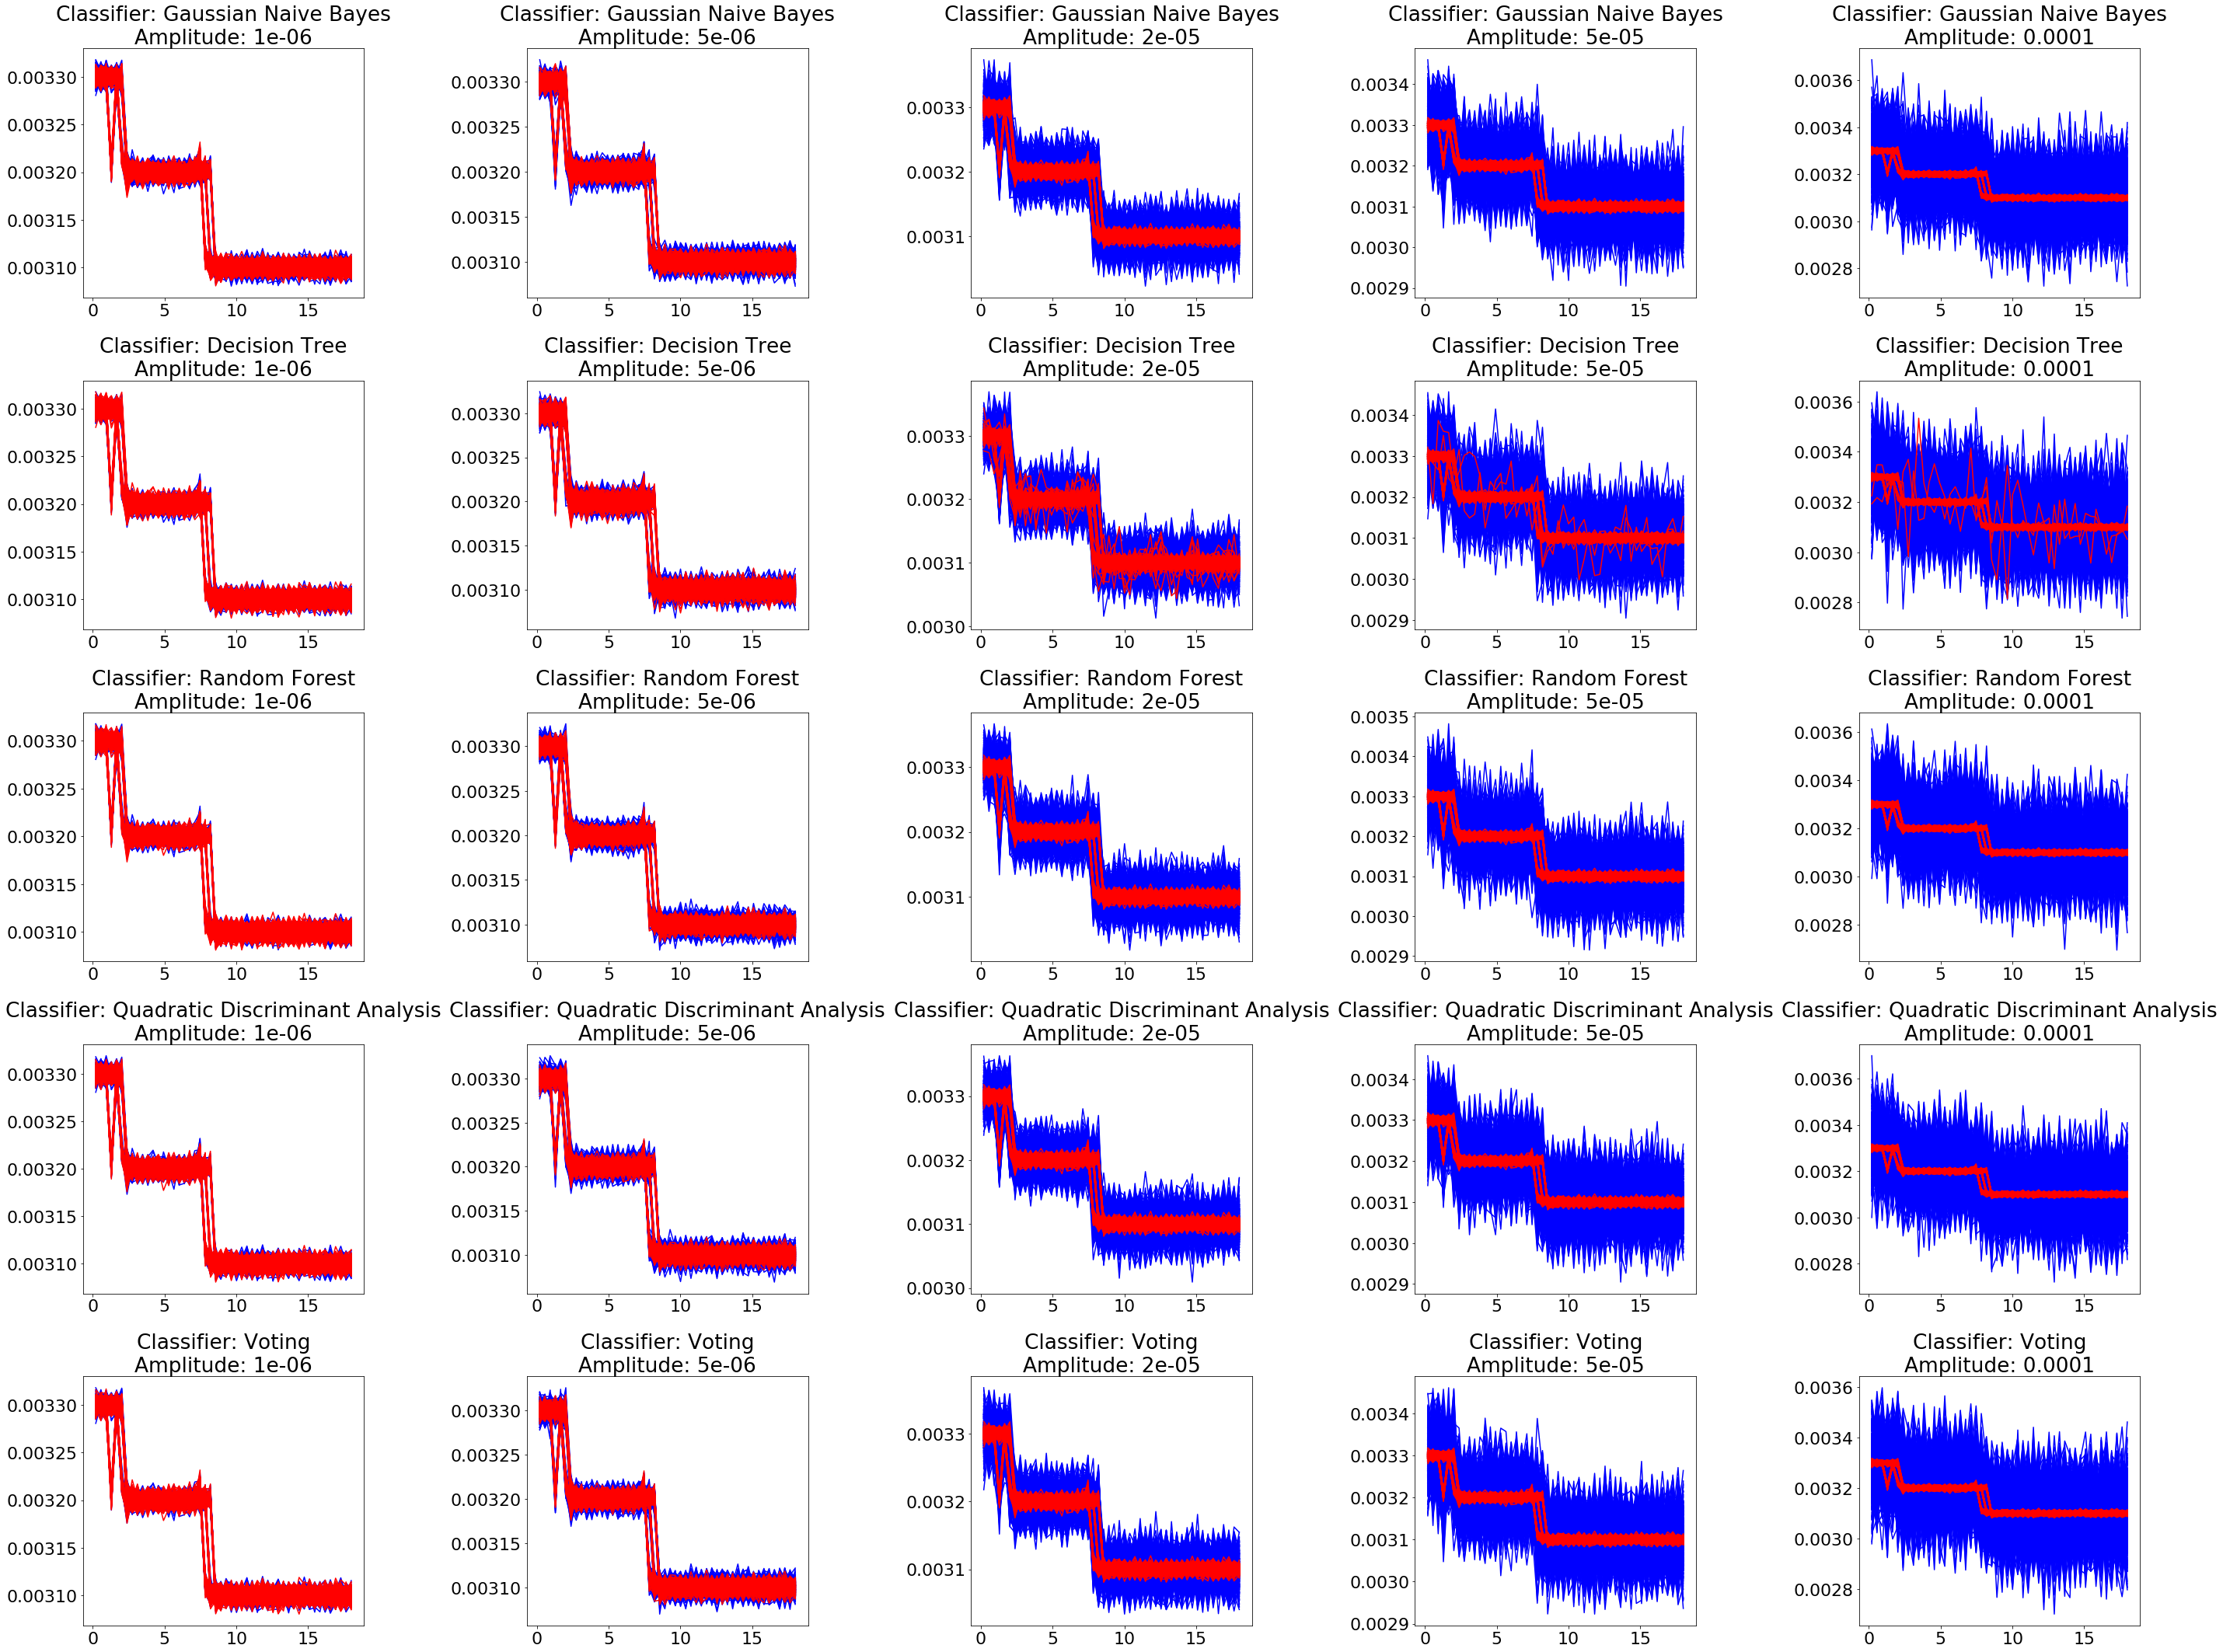

In [12]:
plt.tight_layout()
plt.show()